In [1]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

def displayFrequencyResponse(b, a=[1], num=None, mag='log', new_figure=True, **kwargs):
    w, Hw = sig.freqz(b, a)
    H_amp = np.abs(Hw)
    H_phase = np.unwrap(np.angle(Hw, deg=True), period=360)
    if new_figure==True:
        if num is not None:
            plt.close(num)
        fig, [ax1, ax2] = plt.subplots(num=num, nrows=2)
    else :
        fig = plt.figure(num=num)
        ax1 = fig.axes[0]
        ax2 = fig.axes[1]
    
    if mag.lower()=='log':
        ax1.plot(w, 20*np.log10(H_amp), **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$ (dB)')
    else:
        ax1.plot(w, H_amp, **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$')

    ax1.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    #ax1.set_xlabel(r'Normalized Angular Frequency $\hat{\omega}$')

    ax1.set_xlim([0, pi])
    ax1.set_title(r'Frequency Response $H\left(\hat{\omega}\right)$')

    phaseResp, = ax2.plot(w, H_phase, **kwargs)

    ax2.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax2.set_xlabel(r'Normalized Angular Frequency $\hat{\omega}$')
    ax2.set_ylabel(r'$\angle H(\hat{\omega})$')
    
    yticks = ax2.get_yticks()
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([f'${x}^\\circ$' for x in yticks])

    if "label" in kwargs.keys():
        ax2.legend()
        ax1.legend()
    fig.tight_layout(pad=0.1, w_pad=1.0, h_pad=1.0)

# Enable importing from modules in top-level directory
from sys import path
if path[0] != '..': path.insert(0, '..')

%matplotlib widget

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Filtering in the Frequency Domain

* **Emne AIS2201 - Digital Signal Processing**
* **Week 44, 2025**
* **Lecturer: Kai Erik Hoff**

# Topics

* Gibbs Phenomenon
* Designing Filters using Frequency Sampling
* Fast Convolution

# Filtering by manipulating FFT samples

* It is tempting to approach signal filtering by adjusting the frequency content of unwanted frequencies to $0$
    * We did this in assignment 4
    * Below is shown an example with a sawtooth wave

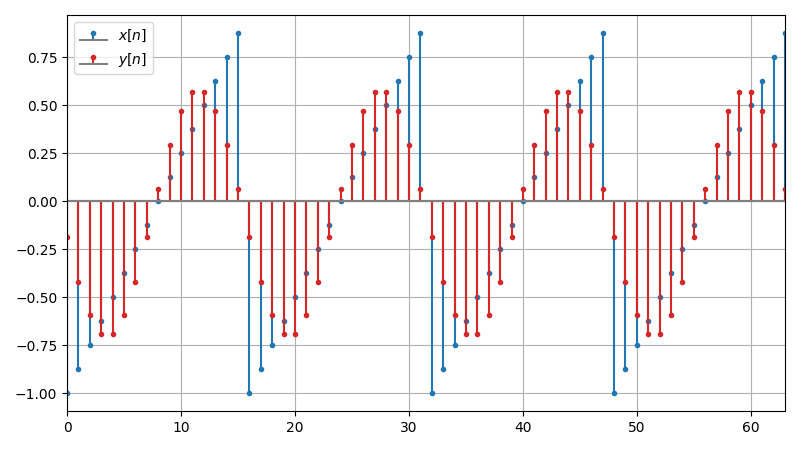

In [2]:
n = np.arange(64)
xn = sig.sawtooth(n*2*np.pi/16) # 4 sawtooth periods over signal duration
Xm = np.fft.rfft(xn)
m = np.arange(len(Xm))
Hm = np.where(m > 4, 0, 1) # Suppress every frequency component above f_norm = 4/64
Ym = Hm*Xm
yn = np.fft.irfft(Ym)
plt.close(1); plt.figure(1)
plt.stem(xn, markerfmt='.C0', linefmt='C0', label="$x[n]$", basefmt='grey')
plt.stem(yn, markerfmt='.C3', linefmt='C3', label="$y[n]$", basefmt='grey')
plt.legend()

* Appears to be doing exactly what we want.
    * A $\hat{f} = \frac{4}{64} \text{Hz}$ sawtooth wave only contains **one** sinusoid with frequency $\hat{f} \leq \frac{4}{64} \text{Hz}$.

* Let's use what we know about FIR filter analysis to take a closer look!

# Impulse response for FFT-based filtering

* We filter a simple impulse signal $\delta[n]$ defined for $n \in (0, 64]$:


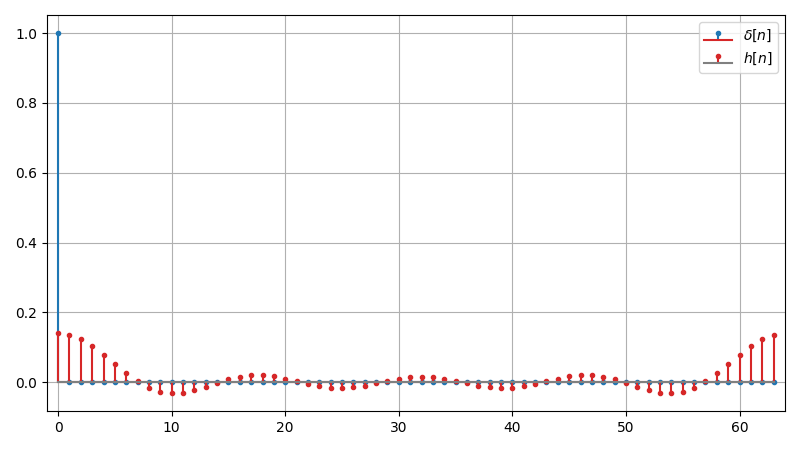

In [3]:
n = np.arange(64)
dn = np.where(n==0, 1, 0)
Dm = np.fft.rfft(dn)
m = np.arange(len(Dm))
Hm = Dm*np.where(m >4, 0, 1)
hn = np.fft.irfft(Hm)
plt.close(2); plt.figure(2)
plt.stem(dn, markerfmt='.C0', linefmt='C0', label="$\\delta[n]$")
plt.stem(hn, markerfmt='.C3', linefmt='C3', label="$h[n]$", basefmt='grey')
plt.xlim([-1, 64])
plt.legend()

* Zero delay between input impulse peak, and peak value in impulse response
    * Implies phase response $\angle H(\hat{\omega}) = 0^{\circ}$

* The fourier "assumption" of periodicity beyond the window scope results in *circular convolution*

## Recap: circular convolution

Output()

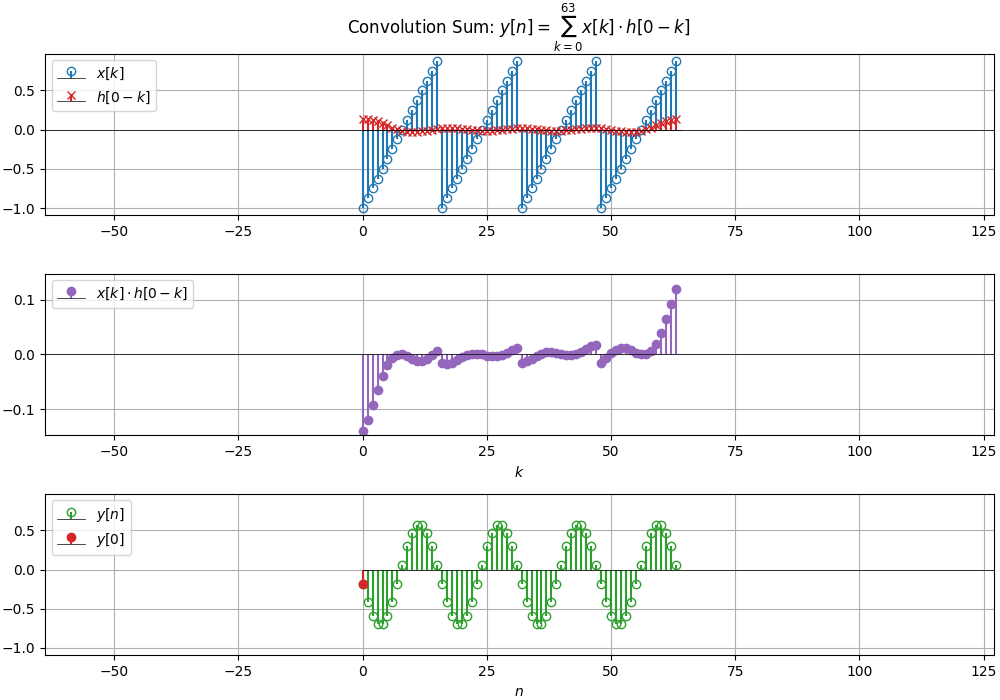

In [4]:
from demos import ConvolutionDemo
ConvolutionDemo(xn, hn, fig_num=3,figsize=(10,7)).conv_mode.set_trait(name='value', value="circular")   #

# Frequency response

Text(0.5, 0, 'Digital Frekvens $\\hat{\\omega} \\ (\\times \\pi)$')

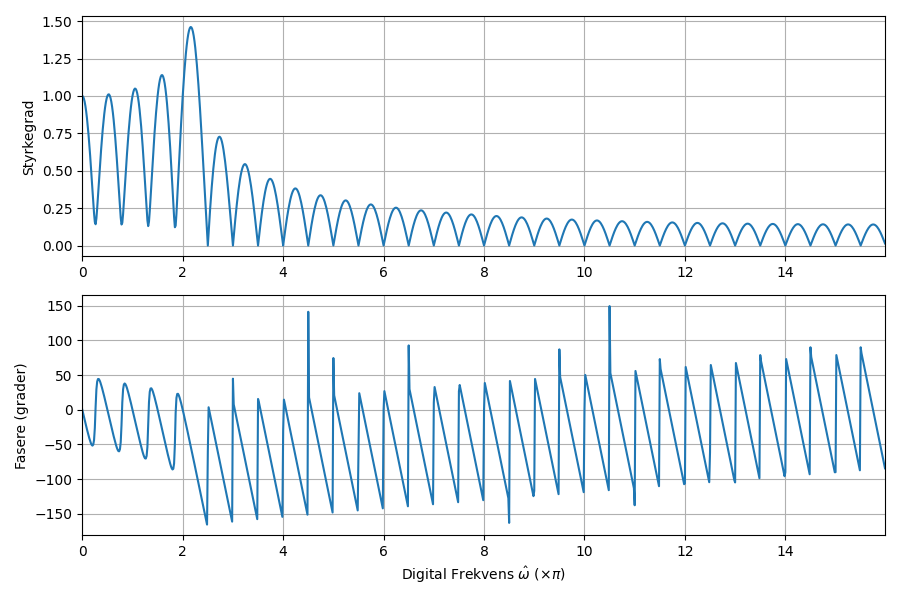

In [5]:
f, Hf = sig.freqz(hn, worN=1024, fs=32)

Hw_amp = np.abs(Hf)
Hw_phase = np.angle(Hf)
plt.close(4); plt.figure(4, figsize=(9,6))
plt.subplot(2,1,1)
plt.plot(f, Hw_amp)
plt.ylabel('Styrkegrad')
plt.subplot(2,1,2)
plt.plot(f, np.rad2deg(Hw_phase))
plt.ylabel('Fasere (grader)')
plt.xlabel(r'Digital Frekvens $\hat{\omega} \ (\times \pi)$')

* Spectral leakage on steroids.
    * Actual name: [Gibbs Phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon)

* Attempting phase response $\angle H[m] = 0^{\circ}$ causes significant distortion between frequency-domain samples $m$

# How *should* the FFT be used for filtering?

1. Introduce $\frac{M-1}{2}$ samples of delay in the frequency domain (as with "regular" FIR filters)
    * $M$ is length of FFT window
    * $H_{\text{shifted}}[m] = H[m]\cdot e^{-j2\pi \cdot \frac{M-1}{2} \cdot \frac{m}{M}}$
    * Known as frequency sampling method.

2. Use Zero Padding to "cancel out" effects of circular convolution
    * Both input signal $x[n]$ and filter impulse response $h[n]$ must be padded to length $L_x + M - 1$ before FFT
    * Multiply FFT's and calculate IFFT
    * Known as Fast Convolution

# Frequency sampling filter design

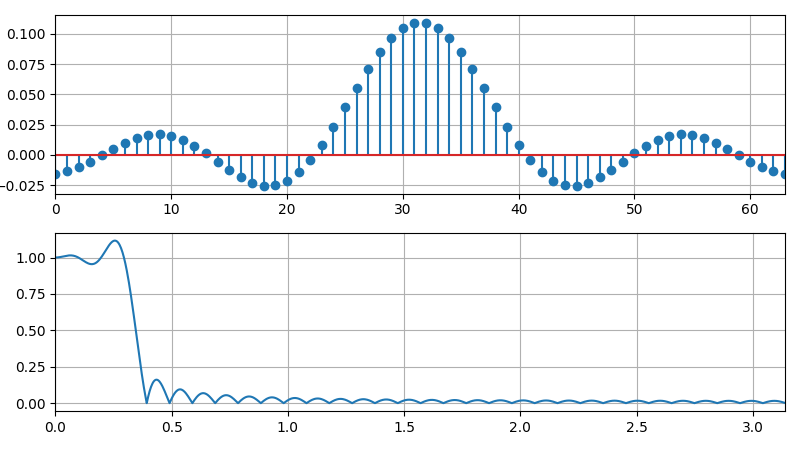

In [6]:
M = 64
m = np.arange(M//2)

# "Brick Wall" filter
Hm = np.ones(M//2) + 0j # Initialize as allpass
Hm[4:] = 0 # Define stopband

Hm *= np.exp(-2j*np.pi*(M-1)/2*m/M) # Add group delay equal to half the filter order

hn = np.fft.irfft(Hm, n=M) # Calculate the IDFT

w, Hw = sig.freqz(hn, worN=1024)

plt.close(5); plt.figure(5)
plt.subplot(2,1,1)
plt.stem(hn)
plt.subplot(2,1,2)
plt.plot(w, np.abs(Hw))

* "Brick Wall" lowpass filters produce an impulse response similar (but not identical) in shape to $\text{sinc}(x)$
    * Manually adding a transition band will improve filter attenuation

* Why use the method?
    * Easy way to create filter with ***any*** concievable frequency response.

## Demo: zero padding and circular convolution

Output()

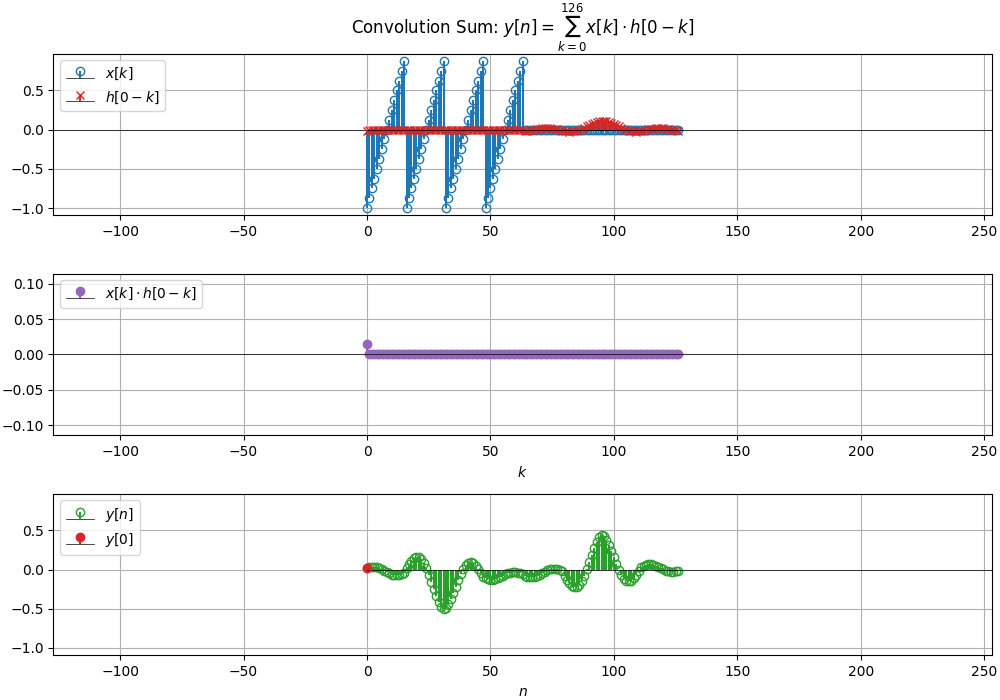

In [7]:
from demos import ConvolutionDemo

ConvolutionDemo(np.concatenate((xn, np.zeros(len(hn)-1))), # Add zeroes to input signal
                np.concatenate((hn, np.zeros(len(xn)-1))), # Add zeroes to impulse respone
                fig_num=6,figsize=(10,7)).conv_mode.set_trait(name='value', value="circular")   #

# Fast convolution

* Replaces convolution with mulitplication $x[n]*h[n] \stackrel{\mathrm{DTFT}}{\longleftrightarrow} X\left(\hat{\omega}\right)\cdot H \left(\hat{\omega}\right)$ employing FFT/IFFT
* Both sequences need to be padded to length of fully convolved output in advance
* Computationally more efficent when number of filter taps $M$ is high (approx. $>80$)
#### Code example:

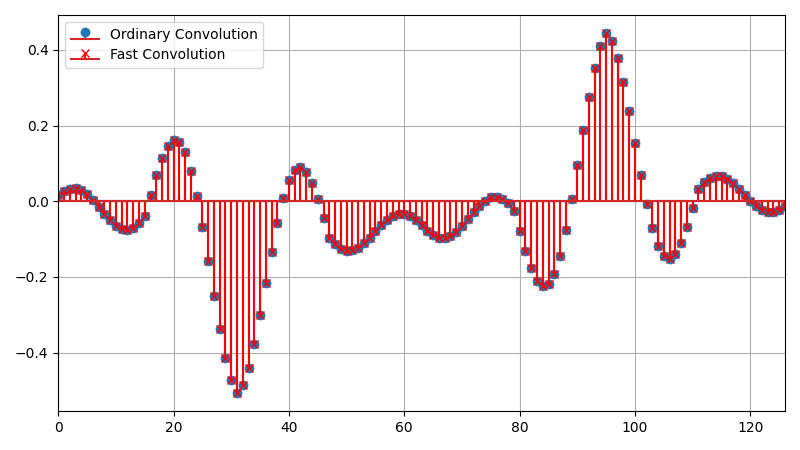

In [8]:
L_y = len(xn) + len(hn) -1

Xm = np.fft.rfft(xn, n=L_y)
Hm = np.fft.rfft(hn, n=L_y)
Ym = Xm*Hm
yn = np.fft.irfft(Ym, n=L_y)

plt.close(7);plt.figure(7)
plt.stem(np.convolve(xn, hn), label="Ordinary Convolution")
plt.stem(yn, markerfmt="xr", linefmt="r", label="Fast Convolution")
plt.legend()

# Filtering signals in blocks

* When implementing digital filters to filter streams of sampled data in "real-time", it is often advantageous to filter the signal in "blocks"

* Output signal "tail" from each block must be added to the next block to ensure a "smooth" convolution operation on the full signal.

# Questions?